In [1]:
!pip install seaborn
!pip install nltk
!pip install datasets
!pip install keras_nlp

import logging
import time
import nltk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
import tensorflow as tf
import keras_nlp
import pathlib
import random
from tensorflow import keras
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)

2023-05-23 21:06:43.246657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# define our parameters/hyperparameters
BATCH_SIZE = 64
EPOCHS = 15  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 40
ENG_VOCAB_SIZE = 10000
LUG_VOCAB_SIZE = 10000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [3]:
import pandas as pd
from datasets import load_dataset

# Load the Tatoeba dataset for English and Luganda using load_dataset()
new_dataset = load_dataset('sbmaruf/forai_ml_masakhane_mafand', 'en-lug')

# Access the train, test and validation split of the dataset
train_set = new_dataset['train']
test_set = new_dataset['test']
val_set = new_dataset['validation']

# Extract the sentence pairs from the dataset split
train_pairs = [(data['source'].lower(), data['target'].lower()) for data in train_set]
test_pairs = [(data['source'].lower(), data['target'].lower()) for data in test_set]
val_pairs = [(data['source'].lower(), data['target'].lower()) for data in val_set]

random.shuffle(train_pairs)
random.shuffle(test_pairs)
random.shuffle(val_pairs)

print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

Found cached dataset forai_ml_masakhane_mafand (/home/belinda/.cache/huggingface/datasets/sbmaruf___forai_ml_masakhane_mafand/en-lug/1.0.0/5983862e8f5e8cbca281d4e2ad5a14eb519b574d59f49faad0d7f107d12a3912)


  0%|          | 0/3 [00:00<?, ?it/s]

4075 training pairs
1500 validation pairs
1500 test pairs


In [4]:
# tokenize the data
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [6]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

lug_samples = [text_pair[1] for text_pair in train_pairs]
lug_vocab = train_word_piece(lug_samples, LUG_VOCAB_SIZE, reserved_tokens)

2023-05-23 21:10:38.127149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]
2023-05-23 21:10:50.756643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]


In [7]:
print("English Tokens: ", eng_vocab[100:110])
print("Luganda Tokens: ", lug_vocab[100:110])

English Tokens:  ['museveni', 'be', 'national', 'people', 'president', '##y', 'will', '##e', 'said', '##n']
Luganda Tokens:  ['bw', 'ekitongole', 'agamba', 'olw', 'ba', 'kye', 'kino', 'buli', 'lw', 'ssente']


In [8]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
lug_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=lug_vocab, lowercase=False
)

In [9]:
eng_input_ex = train_pairs[0][0]
eng_tokens_ex = eng_tokenizer.tokenize(eng_input_ex)
print("English sentence: ", eng_input_ex)
print("Tokens: ", eng_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    eng_tokenizer.detokenize(eng_tokens_ex),
)

print()

lug_input_ex = train_pairs[0][1]
lug_tokens_ex = lug_tokenizer.tokenize(lug_input_ex)
print("Luganda sentence: ", lug_input_ex)
print("Tokens: ", lug_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    lug_tokenizer.detokenize(lug_tokens_ex),
)

English sentence:  on the first day of the conference bukenya spent the most of the day doing damage control and denouncing the media reports.
Tokens:  tf.Tensor(
[  77   67  227  397   69   67  323  286   50 1323  154   67  199   69
   67  397  951   35 1399  235  947   71   35  333  125  164 1436   67
  334  860   14], shape=(31,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'on the first day of the conference bukenya spent the most of the day doing damage control and denouncing the media reports .', shape=(), dtype=string)

Luganda sentence:  ekitundu ekisinga eky'olunaku olwasooka olw'olukungaana, bukenya yakimala agezaako okumatiza abantu nti ebyayogeddwa emikutu gy'eby'empuliziganya tebyabadde bituufu.
Tokens:  tf.Tensor(
[ 450  861  120    7   45  444 1030  646  296  103    7  668   11  301
   89  601  373  801 1164  256  457  124  239  123   70   66  768  114
  361  144 1592  198    7   74    7  407   50  181 1079 1077 1441   13], shape=(42,), dtype=int32)
Recov

In [10]:
def preprocess_batch(eng, lug):
    batch_size = tf.shape(lug)[0]

    eng = eng_tokenizer(eng)
    lug = lug_tokenizer(lug)

    # Pad `eng` to `MAX_SEQUENCE_LENGTH`.
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)

    # Add special tokens (`"[START]"` and `"[END]"`) to `lug` and pad it as well.
    lug_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=lug_tokenizer.token_to_id("[START]"),
        end_value=lug_tokenizer.token_to_id("[END]"),
        pad_value=lug_tokenizer.token_to_id("[PAD]"),
    )
    lug = lug_start_end_packer(lug)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": lug[:, :-1],
        },
        lug[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, lug_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    lug_texts = list(lug_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, lug_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [11]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

2023-05-23 21:11:55.524137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4075]
	 [[{{node Placeholder/_1}}]]
2023-05-23 21:11:55.524752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]


inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


2023-05-23 21:11:56.060682: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
## Building the model

# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=LUG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(LUG_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Train the model and store the history
history = transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_8  (None, None, 256)   2570240     ['encoder_inputs[0][0]']         
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_4 (Transfo  (None, None, 256)   1315072     ['token_and_position_em

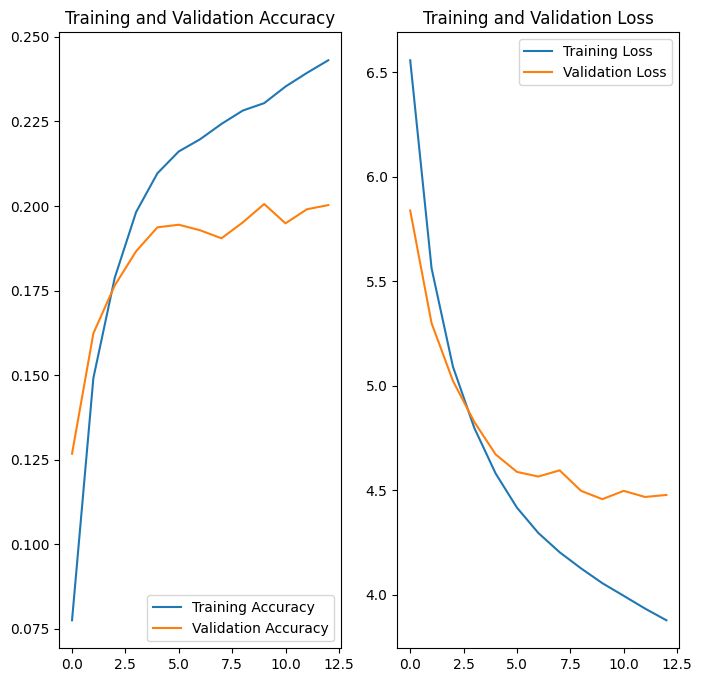

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
transformer.save("saved_transformer.h5")